# Self-Driving Car Engineer Nanodegree


## Project: **Vehicle Detection and Tracking** 
***



## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import glob
import cv2
import time
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
#import pickle
%matplotlib inline
from sklearn.model_selection import train_test_split


## Model Training ##

In [732]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block,
                    vis=False, feature_vec = True):
    '''
    function to extract HOG features
    '''
    if vis == True:
        features, hog_image = hog(img, orientations = orient,
                                 pixels_per_cell = (pix_per_cell, pix_per_cell),
                                 cells_per_block = (cell_per_block, cell_per_block),
                                 transform_sqrt = True,
                                 visualise = vis, feature_vector = feature_vec)
        return features, hog_image
    
    else:
        features = hog(img, orientations = orient,
                                 pixels_per_cell = (pix_per_cell, pix_per_cell),
                                 cells_per_block = (cell_per_block, cell_per_block),
                                 transform_sqrt = True,
                                 visualise = vis, feature_vector = feature_vec)
    return features

def bin_spatial(img, size = (32, 32)):
    features = cv2.resize(img, size).ravel()
    
    return features

def color_hist(img, nbins = 32, bins_range = (0, 256)):
    
    chan1_hist = np.histogram(img[:,:,0], bins = nbins, range = bins_range)
    chan2_hist = np.histogram(img[:,:,1], bins = nbins, range = bins_range)
    chan3_hist = np.histogram(img[:,:,2], bins = nbins, range = bins_range)
    
    hist_features = np.concatenate((chan1_hist[0], chan2_hist[0], chan3_hist[0]))

    return hist_features

def extract_features(imgs, color_space = 'RGB', spatial_size = (32, 32),
                    hist_bins = 32, orient = 9, pix_per_cell = 8, cell_per_block = 2,
                    hog_channel = 0, spatial_feature = True, hist_feature = True,
                    hog_feature = True):
    '''
    extract all features from all images provided for training
    the model
    '''
    features = []
    
    for file in imgs:
        f_features = []
        # cv2 gives range 0 ~ 255
        image = cv2.imread(file)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        if color_space != 'RGB':
            if color_space == 'HSV':
                f_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'HLS':
                f_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'LUV':
                f_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'YUV':
                f_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                f_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else:
            f_image = np.copy(image)

        # extran raw pixels features
        if spatial_feature == True:
            s_feat = bin_spatial(f_image, size = spatial_size)
            f_features.append(s_feat)
        
        # extract color histogram features
        if hist_feature == True:
            h_feat = color_hist(f_image, nbins = hist_bins)
            f_features.append(h_feat)
            
        # extract HOG features    
        if hog_feature == True:
            if hog_channel == 'All':
                hog_feat = []
                for channel in range(f_image.shape[2]):
                    hog_feat.append(get_hog_features(f_image[:,:,channel],
                                                    orient, pix_per_cell, 
                                                    cell_per_block, vis = False, feature_vec = True))
                hog_feat = np.ravel(hog_feat)
            else:
                hog_feat = get_hog_features(f_image[:,:,hog_channel],
                                            orient, pix_per_cell, 
                                            cell_per_block, vis = False, feature_vec = True)
            
            f_features.append(hog_feat)
        
        features.append(np.concatenate(f_features))
    
    return features


In [733]:
colorspace = 'YCrCb'
orient = 12
pix_per_cell = 8
cell_per_block = 1
hog_channel = 'All'
hist_bins = 128
hist_feature = True
hog_feature = True
spatial_feature = True
spatial_size = (16, 16)

In [734]:
cars = []
notcars = []

# all vehicle images
for folder in ['GTI_Far', 'GTI_Left', 'GTI_MiddleClose', 'GTI_Right', 
              'KITTI_extracted']:
    images = glob.glob("vehicles/" + folder + "/*.png")
    for image in images:
        cars.append(image)
# all non-vehicle images        
for folder in ['Extras', 'GTI']:
    images = glob.glob("non-vehicles/" + folder + '/*.png')
    for image in images:
        notcars.append(image)
        
# extract feature vectors
t = time.time()
car_features = extract_features(cars, color_space = colorspace, hist_bins = hist_bins, orient = orient,
                               pix_per_cell = pix_per_cell, cell_per_block = cell_per_block,
                               hog_channel = hog_channel, spatial_feature = spatial_feature,
                               hist_feature = hist_feature, hog_feature = hog_feature,
                               spatial_size = spatial_size)
notcar_features = extract_features(notcars, color_space = colorspace, hist_bins = hist_bins, orient = orient,
                               pix_per_cell = pix_per_cell, cell_per_block = cell_per_block,
                               hog_channel = hog_channel, spatial_feature = spatial_feature,
                               hist_feature = hist_feature, hog_feature = hog_feature,
                               spatial_size = spatial_size)

t2 = time.time()

print("extract features: ", round(t2 -t, 2))
print(car_features[0].shape, notcar_features[0].shape)
x = np.vstack((car_features, notcar_features)).astype(np.float64)

# normalize the features
x_scaler = StandardScaler().fit(x)

scaled_x = x_scaler.transform(x)

# label vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

rand_state = np.random.randint(0, 100)

# split the dataset into train and test
x_train, x_test, y_train, y_test = train_test_split(scaled_x, y, test_size = 0.2, random_state = rand_state)

svc = LinearSVC()

# training Linear SVC
t = time.time()

svc.fit(x_train, y_train)
t2 = time.time()

print("Training:", round(t2 - t))

print("prediction:", round(svc.score(x_test, y_test), 4))
    

extract features:  118.18
(3456,) (3456,)
Training: 2
prediction: 0.9949


## Image Processing ##

In [735]:
# smoothing over multiple images
avg_num = 10
heat_thresh = 10

from scipy.ndimage.measurements import label

def add_heat(heatmap, boxes):
    for box in boxes:
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    
    return heatmap

def apply_threshold(heatmap, threshold):
    heatmap[heatmap < threshold] = 0
    
    return heatmap

def draw_labeled_boxes(img, labels):
    for number in range(1, labels[1] + 1):
        nonzero = (labels[0] == number).nonzero()
        nonzerox = np.array(nonzero[1])
        nonzeroy = np.array(nonzero[0])
        
        box = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        cv2.rectangle(img, box[0], box[1], (0, 0, 255), 4)
    
    return img

def draw_boxes(img, boxes): 
    '''
    draw boxes on the image based on the potential boxes
    '''
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    # get heatmap over the last several frames
    for i in range(len(boxes)):
        heat = add_heat(heat, boxes[i])
        
    # apply threshold to eliminate false positives
    heat = apply_threshold(heat, heat_thresh)
    
    heatmap = np.clip(heat, 0, 255)
    
    labels = label(heatmap)
    
    # draw bounding boxes based on labels
    draw_img = draw_labeled_boxes(img, labels)
    
    return draw_img

def find_cars(img, y_start, y_stop, scale, svc, x_scaler):
    '''
    find all possible cars and return all the boxes
    '''
   
    img_tosearch = img[y_start:y_stop,:,:]
    # use cv2 funtion, should be fine, always keep range as 0 ~ 255
    # if from training result, the best color space is not RGB, need to 
    # convert to that color space first
    ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    
    # resize search area based on scale factor
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1] / scale), np.int(imshape[0] / scale)))
    
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]
    
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1
    
    nfeat_per_block = orient * cell_per_block**2
    
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # get hog feature for the whole search area
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec = False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec = False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec = False)
    
    boxes = []
    for xb in range(nxsteps + 1):
        for yb in range(nysteps + 1):
            img_features = []
            ypos = yb * cells_per_step
            xpos = xb * cells_per_step
            
            # get hog feature for current window
            hog_feat1 = hog1[ypos:ypos + nblocks_per_window, xpos:xpos + nblocks_per_window].ravel()
            hog_feat2 = hog2[ypos:ypos + nblocks_per_window, xpos:xpos + nblocks_per_window].ravel()
            hog_feat3 = hog3[ypos:ypos + nblocks_per_window, xpos:xpos + nblocks_per_window].ravel()
            # make sure hog_features has the same size as that used in training
            if hog_channel == 'All':
                hog_features = np.concatenate((hog_feat1, hog_feat2, hog_feat3))
            elif hog_channel == 0:
                hog_features = hog_feat1
            elif hog_channel == 1:
                hog_features = hog_feat2
            else:
                hog_features = hog_feat3
                
            xleft = xpos * pix_per_cell
            ytop = ypos * pix_per_cell
            # I don't think resize is needed here. Window must be 64, otherwise, the size of hog_features will not match
            # that in training
            #subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, x_left:x_left+window], (64, 64))
            subimg = ctrans_tosearch[ytop:ytop+window, xleft:xleft+window]
            
            # get bin spatial features and histogram features
            spatial_features = bin_spatial(subimg, size = spatial_size)
            hist_features = color_hist(subimg, nbins = hist_bins)
            
            if spatial_feature == True:
                img_features.append(spatial_features)
            if hist_feature == True:
                img_features.append(hist_features)
            if hog_feature == True:
                img_features.append(hog_features)
            
            test_features = np.concatenate(img_features)
            # normalize the feature vector
            test_features = x_scaler.transform(test_features.reshape(1, -1))
            # prediction using the trained model
            test_prediction = svc.predict(test_features)
            
            # save the box if it contains a car
            if test_prediction == 1:
                xbox_left = np.int(xleft * scale)
                ytop_draw = np.int(ytop * scale)
                win_draw = np.int(window * scale)
                boxes.append(((xbox_left, ytop_draw + y_start),
                              (xbox_left + win_draw, ytop_draw + win_draw + y_start)))
    return boxes
   

def pipeline(img, boxes = []):
    '''
    find all cars on the input image, and return an image with 
    possible cars marked
    this function expects image in RGB format, range 0 ~ 255
    '''
    # search area [ystart, ystop, scale]                     
    search_areas = [[392, 472, 1], [408, 504, 1.5], [408, 536, 2], [408, 600, 3]]

    img_boxes = []
    # get all boxes from current frame
    for area in search_areas:                       
        img_boxes += find_cars(img, area[0], area[1], area[2], svc, x_scaler)
    # save to the boxes list over the last several frames
    boxes.append(img_boxes)
    # only keep the result for the last avg_num frames
    boxes = boxes[-avg_num:]
    
    # show result for single image case
    if from_video == 0:
        num_box = 0
        temp = np.copy(img)
        for i in range(len(boxes)):
            num_box += len(boxes[i])
            for box in boxes[i]:
                cv2.rectangle(temp, box[0], box[1], (0, 255, 0), 6)
        print(num_box)
        plt.figure()
        plt.imshow(temp)

    draw_boxes(img, boxes)

    return img, boxes
    

3


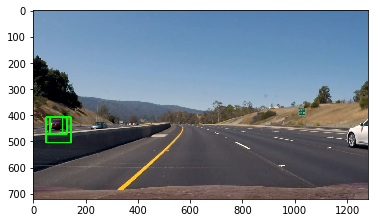

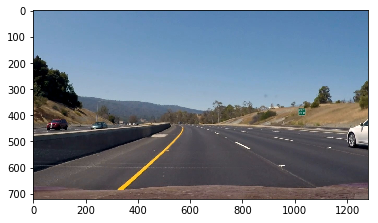

In [758]:
import os
from_video = 0
boxes = []

test_img = cv2.imread("org/136.jpg")
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
processed, boxes = pipeline(test_img, boxes)
plt.figure()
plt.imshow(processed)

## Video Processing ##

In [164]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [727]:
from_video = 1
# save all frames in test_video to a foler
clip = VideoFileClip("test_video.mp4")
frames = clip.iter_frames()
total = 1
for frame in frames:
    cv2.imwrite("org_test/"+ str(total) + ".jpg", cv2.cvtColor(frame, cv2.COLOR_RGB2BGR))
    total += 1
print('done')

#white_clip = clip.fl_image(pipeline)

#%time white_clip.write_videofile("test_video_output.mp4", audio = False)

done


In [736]:
boxes = []
from_video = 1
# process each frame
for file in os.listdir('org_test'):
    test_img = cv2.imread("org_test/" + file)
    test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
    processed, boxes = pipeline(test_img, boxes)
    cv2.imwrite('dbg_test_s/' + file, cv2.cvtColor(processed, cv2.COLOR_RGB2BGR))
print("single image handling done")

single image handling done


In [737]:
# generate video from processed frames
imgs_list = ["dbg_test_s/{}.jpg".format(i) for i in range(1, 39)]
clip = ImageSequenceClip(imgs_list, fps=24)
clip.write_videofile('test_s.mp4')


[MoviePy] >>>> Building video test_s.mp4
[MoviePy] Writing video test_s.mp4


100%|██████████| 39/39 [00:00<00:00, 50.07it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_s.mp4 



In [467]:
from_video = 1
clip = VideoFileClip("project_video.mp4")
# save all frames of the project video to a folder
frames = clip.iter_frames()
total = 1
for frame in frames:
    cv2.imwrite("org/"+ str(total) + ".jpg", cv2.cvtColor(frame, cv2.COLOR_RGB2BGR))
    total += 1
    if total % 100 == 0:
        print(total)


100
200
300
400
500
600
700
800
900
1000
1100
1200


In [738]:
from_video = 1
boxes = []
total = 1
# process each frame and save the results to another folder
imgs_org_list = ["{}.jpg".format(i) for i in range(1, 1261)]
for file in imgs_org_list:
    test_img = cv2.imread("org/" + file)
    test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
    processed, boxes = pipeline(test_img, boxes)
    cv2.imwrite('dbg_s/' + file, cv2.cvtColor(processed, cv2.COLOR_RGB2BGR))
    total += 1
    if total % 100 == 0:
        print(total)
print("single image handling done")

100
200
300
400
500
600
700
800
900
1000
1100
1200
single image handling done


In [739]:
# generate video for the project
imgs_list = ["dbg_s/{}.jpg".format(i) for i in range(1, 1261)]
clip = ImageSequenceClip(imgs_list, fps=24)
clip.write_videofile('project_s.mp4')

[MoviePy] >>>> Building video project_s.mp4
[MoviePy] Writing video project_s.mp4


100%|██████████| 1260/1260 [00:54<00:00, 23.26it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_s.mp4 

